**1. Training and Evaluating an MLP Classifier on the FashionMNIST dataset using PyTorch**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [ ]:
# Retrieving the FashionMNIST dataset as training and testing sets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [ ]:
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")

# Images Train: 60000
# Images Test:  10000


In [ ]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


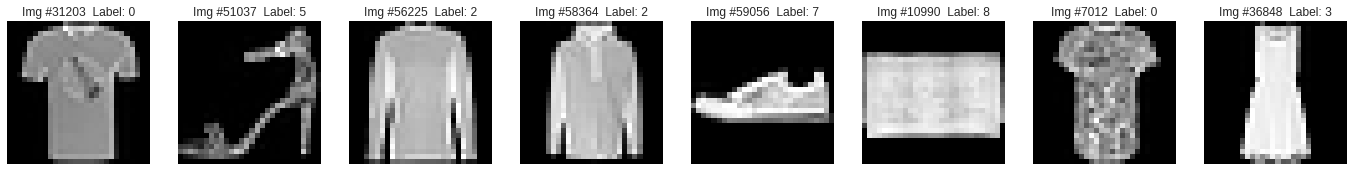

In [ ]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [ ]:
BATCH_SIZE = 64
SHUFFLE_TRAIN = True

In [ ]:
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [ ]:
imgs, labels = next(iter(eval_loader))
print(f"imgs.shape = {imgs.shape}")
print(f"labels.shape = {labels.shape}")

imgs.shape = torch.Size([64, 1, 28, 28])
labels.shape = torch.Size([64])


In [ ]:
for i, (imgs, labels) in enumerate(eval_loader):
    print(f"Iterating batch #{i+1}, which has {len(labels)} elements")
    if i > 10:
        break

Iterating batch #1, which has 64 elements
Iterating batch #2, which has 64 elements
Iterating batch #3, which has 64 elements
Iterating batch #4, which has 64 elements
Iterating batch #5, which has 64 elements
Iterating batch #6, which has 64 elements
Iterating batch #7, which has 64 elements
Iterating batch #8, which has 64 elements
Iterating batch #9, which has 64 elements
Iterating batch #10, which has 64 elements
Iterating batch #11, which has 64 elements
Iterating batch #12, which has 64 elements


In [ ]:
import torch.nn as nn

In [ ]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [ ]:
model = Model(input_dim=784, hidden_dim=128, output_dim=10)
print(model)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
imgs, labels = next(iter(eval_loader))      # sampling images
flattened_imgs = imgs.flatten(start_dim=1)  # reshaping to desired size
output = model(flattened_imgs)              # forward pass through model

print(f"Imgs shape:         {imgs.shape}")
print(f"Model input shape:  {flattened_imgs.shape}")
print(f"Model output shape: {output.shape}")

Imgs shape:         torch.Size([64, 1, 28, 28])
Model input shape:  torch.Size([64, 784])
Model output shape: torch.Size([64, 10])


In [ ]:
from tqdm import tqdm

In [ ]:
def validation(model):
    n_correct = 0

    counter = 1
    epoch_loss_count = 0
    with torch.no_grad():
        progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
        for i, (imgs, labels) in progress_bar: 
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)

            eval_loss = criterion(preds, labels)

            epoch_loss_count += eval_loss.item()

            pred_labels = torch.argmax(preds, dim=-1)
            cur_correct = len(torch.where(pred_labels == labels)[0])
            n_correct = n_correct + cur_correct
            counter+=1
            


    accuracy = n_correct / len(test_dataset) * 100
    return accuracy , (epoch_loss_count/counter)

In [ ]:
NUM_EPOCHS = 30
LR = 1e-3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim = 784, hidden_dim = 256, output_dim=10)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
x_test, y_test = next(iter(eval_loader))
x_test, y_test = x_test.to(device), y_test.to(device)

In [ ]:
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []
train_loss_per_pattern=[]
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    n_correct = 1
    batch_loss = []
    batch_accuracy = []
    epoch_loss_count = 0
    epoch_accuracy = 0
    for i, (imgs, labels) in enumerate(progress_bar):
        
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing error
        loss = criterion(preds, labels)
        train_loss=loss.item()
        batch_loss.append(train_loss)
        epoch_loss_count = np.mean(batch_loss)

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
        # updating parameters
        optimizer.step()


        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct
        
        batch_accuracy.append(100 * cur_correct / n_correct)
        epoch_accuracy = np.mean(batch_accuracy)
        train_loss_per_pattern.append(train_loss)
    
        if(i % 100 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")
    train_loss_list.append(epoch_loss_count)
    train_acc_list.append(epoch_accuracy)
    acc,loss = validation(model)
    eval_loss_list.append(loss)
    train_acc_list.append(epoch_accuracy)
    eval_acc_list.append(acc)


100%|██████████| 157/157 [00:01<00:00, 128.10it/s]


In [ ]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [ ]:
print(f'\nAccuracy: {validation(model)[0]}')

100%|██████████| 157/157 [00:02<00:00, 69.45it/s]


Accuracy: 88.88000000000001


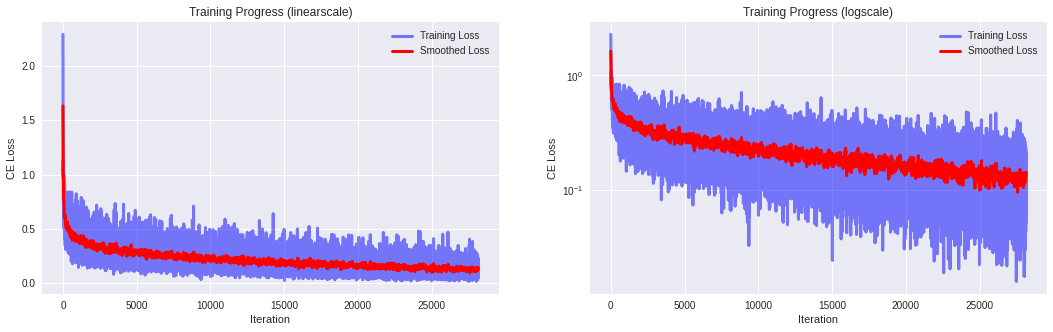

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(train_loss_per_pattern, 31)
ax[0].plot(train_loss_per_pattern, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(train_loss_per_pattern, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

**2. Draw learning curves (train/eval loss, train/eval classification accuracy) and confusion matrix**

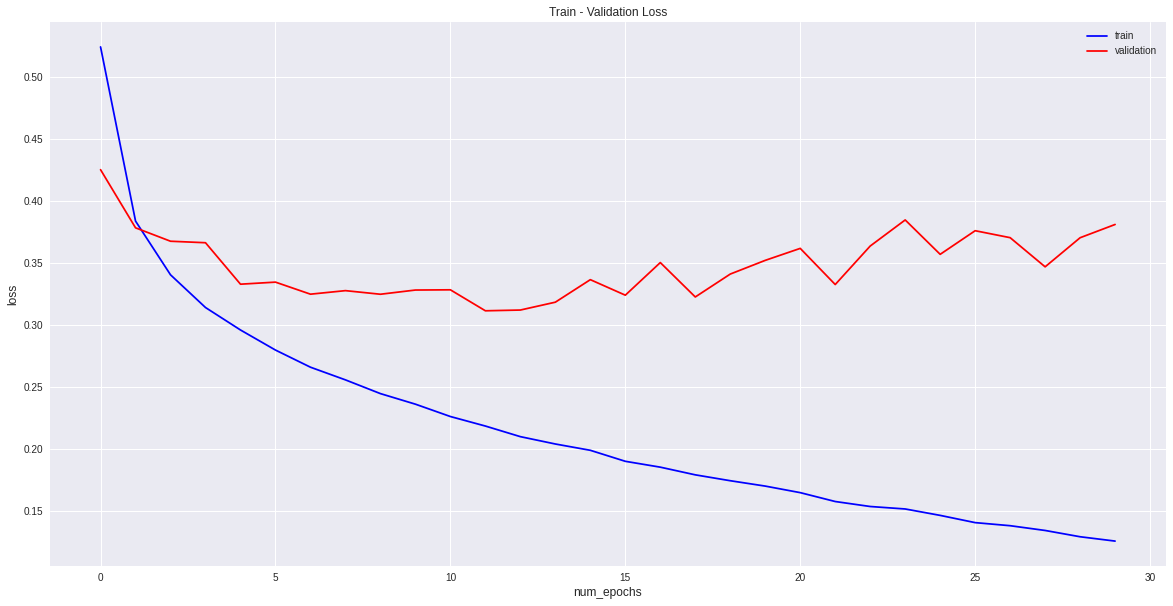

In [ ]:
# This plot show that the training loss is decreasing as go through the epochs, and it is learning well (no fluctuations/ no oscillations).
# The validation graph is somewhat between poor to good generalization

fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss_list, c="blue", label='train')
plt.plot( eval_loss_list, c="red", label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

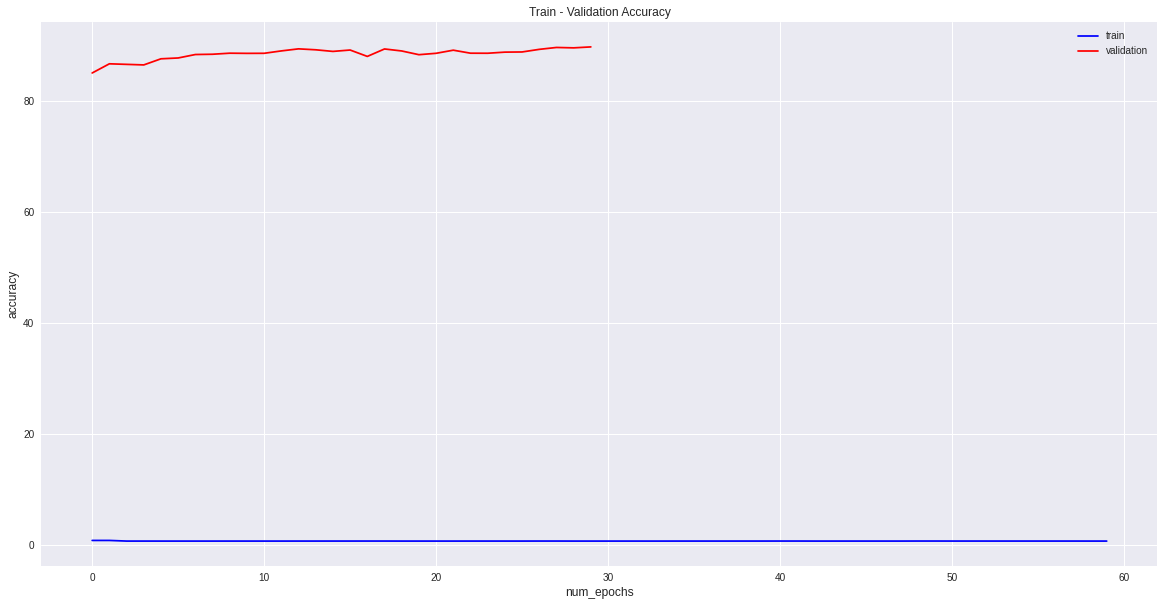

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot( train_acc_list, c="blue", label='train')
plt.plot( eval_acc_list, c="red", label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

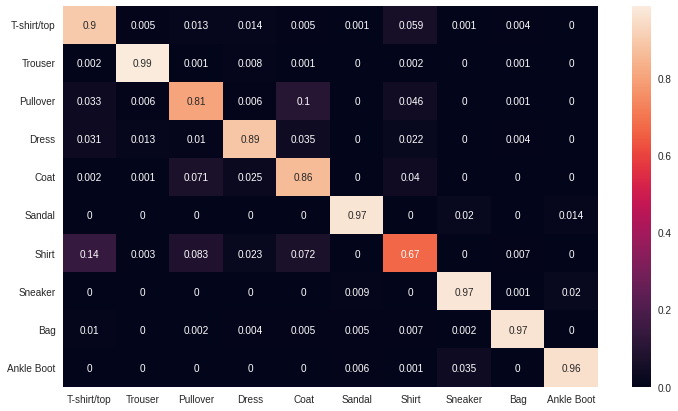

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for imgs, labels in eval_loader:
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        output = model(flattened_imgs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

This confusion matrix show that all of the 10 classes are distinguished between what is true and what is false. 
Some classes are not able to differentiate other classes like shirt vs T-shirt/top , coat vs pullover.
Overall, this represents a good model.

In [ ]:
!pip install --quiet optuna

**3. Using Optuna to optimize (at least) two hyper-parameters and and depicting optimization plots**

In [ ]:
import optuna
import torch.optim as optim
from optuna.trial import TrialState
optuna.__version__

'3.0.3'

In [ ]:
def objective(trial):
    loss_list=[]
    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]) #for hp tuning

    LR = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning

    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
   
    for epoch in range(NUM_EPOCHS):
        model.train()
        # progress_bar = tqdm(train_loader, total=len(train_loader))
        for i, (imgs, labels) in enumerate(train_loader):
            # using GPU
            imgs, labels = imgs.to(device), labels.to(device)
        
            # forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)
        
            # computing error
            loss = criterion(preds, labels)
            loss_list.append(loss.item())

            # removing accumulated gradients
            optimizer.zero_grad()
        
            # backprogating error to compute gradients
            loss.backward()
        
            # updating arameters
            optimizer.step()
        

        # Validation of the model.
        model.train()

        n_correct = 0
        with torch.no_grad():
            
            for i, (imgs, labels) in enumerate(eval_loader): 
                #everything needs to be on the same device
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                # forward pass
                flattened_imgs = imgs.flatten(start_dim=1)
                preds = model(flattened_imgs)

                pred_labels = torch.argmax(preds, dim=-1)
                cur_correct = len(torch.where(pred_labels == labels)[0])
                n_correct = n_correct + cur_correct

        accuracy = n_correct / len(test_dataset)
        # print(f"Test accuracy: {round(accuracy,2)}%")
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
# For optuna trials, we need to pass the parameters in such a way that these parameters maximizes the probability of getting good values.
# We tested several values like n_layers between 1 to 5 and we found the optimal number should be somewhere around 1 to 3 as more layer make this this layer prone to overfitting as we don't have enough samples to 
# train as raw MLP (as opposed to a CNN which can extract image related features from the training dataset)

CLASSES = 10
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 200,300)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    # layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-16 20:12:36,592] A new study created in memory with name: no-name-9fd2e533-8b83-434c-8eef-92e99e43b8fa
[I 2022-11-16 20:22:31,854] Trial 0 finished with value: 0.8726 and parameters: {'n_layers': 1, 'n_units_l0': 286, 'optimizer': 'RMSprop', 'lr': 0.006486807875943038}. Best is trial 0 with value: 0.8726.
[I 2022-11-16 20:27:57,503] Trial 1 finished with value: 0.5064 and parameters: {'n_layers': 2, 'n_units_l0': 225, 'n_units_l1': 215, 'optimizer': 'SGD', 'lr': 4.633295616702865e-05}. Best is trial 0 with value: 0.8726.
[I 2022-11-16 20:33:40,781] Trial 2 finished with value: 0.1388 and parameters: {'n_layers': 2, 'n_units_l0': 296, 'n_units_l1': 232, 'optimizer': 'SGD', 'lr': 1.1064234974427788e-05}. Best is trial 0 with value: 0.8726.
[I 2022-11-16 20:39:42,338] Trial 3 finished with value: 0.8914 and parameters: {'n_layers': 1, 'n_units_l0': 299, 'optimizer': 'Adam', 'lr': 0.000342398526391846}. Best is trial 3 with value: 0.8914.
[I 2022-11-16 20:45:01,137] Trial 4 fini

Accuracy: 0.8914
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 299, 'optimizer': 'Adam', 'lr': 0.000342398526391846}


In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
print("  Accuracy Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  2
  Number of complete trials:  8
Best trial:
  Accuracy Value:  0.8914
  Params: 
    n_layers: 1
    n_units_l0: 299
    optimizer: Adam
    lr: 0.000342398526391846


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['optimizer','lr','n_layers', 'n_units_l1'])

**4. Visualizing the norm of the gradients for some parameters during training, i.e., how the error decreases for some parameters as the model learns**

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

Epoch 5 Iter 938: loss 0.02465. : 100%|██████████| 938/938 [00:42<00:00, 21.82it/s]


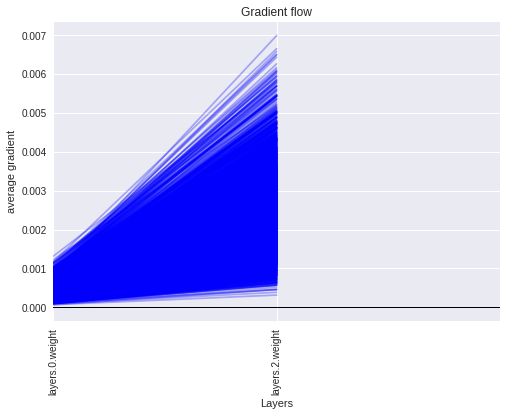

In [ ]:
loss_list = []

for epoch in range(5):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing error
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
        plot_grad_flow(model.named_parameters())

        optimizer.step()
    
        if(i % 100 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")